In [ ]:
# ===============================
# 1. Import Libraries
# ===============================
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
# ===============================
# 2. Load Cats vs Dogs dataset
# ===============================
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
class_names = info.features['label'].names

# Save dataset as images in folders
for i, example in enumerate(dataset['train']):
    image, label = example
    save_dir = f'./cats_vs_dogs/train/{class_names[label]}'
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f'{class_names[label]}_{i}.jpg')
    tf.keras.preprocessing.image.save_img(filename, image.numpy())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.IN2AWK_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
# ===============================
# 3. ImageDataGenerator with Augmentation
# ===============================
datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    './cats_vs_dogs/train',
    target_size=(320, 320),   # higher resolution
    batch_size=256,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    './cats_vs_dogs/train',
    target_size=(320, 320),
    batch_size=256,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 18611 images belonging to 2 classes.
Found 4651 images belonging to 2 classes.


In [ ]:
# ===============================
# 4. Transfer Learning (MobileNetV2)
# ===============================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(320,320,3),
    include_top=False,
    weights='imagenet'
)

# Fine-tune last 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/tmp/ipython-input-1600777361.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [ ]:
# ===============================
# 5. Callbacks
# ===============================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)


In [ ]:
# ===============================
# 6. Train Model
# ===============================
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stop, lr_scheduler]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 710s 9s/step - accuracy: 0.6790 - loss: 0.5965 - val_accuracy: 0.8989 - val_loss: 0.2930 - learning_rate: 1.0000e-05
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 596s 8s/step - accuracy: 0.9281 - loss: 0.2402 - val_accuracy: 0.9564 - val_loss: 0.1455 - learning_rate: 1.0000e-05
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 621s 8s/step - accuracy: 0.9561 - loss: 0.1349 - val_accuracy: 0.9701 - val_loss: 0.0935 - learning_rate: 1.0000e-05
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 593s 8s/step - accuracy: 0.9655 - loss: 0.0985 - val_accuracy: 0.9733 - val_loss: 0.0706 - learning_rate: 1.0000e-05
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 595s 8s/step - accuracy: 0.9720 - loss: 0.0792 - val_accuracy: 0.9759 - val_loss: 0.0630 - learning_rate: 1.0000e-05
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 596s 8s/step - accuracy: 0.9741 - loss: 0.0704 - val_accuracy: 0.9766 - val_loss: 0.0595 - learning_rate: 1.0000e-05
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 600s 8s/step - accuracy: 0.9760 

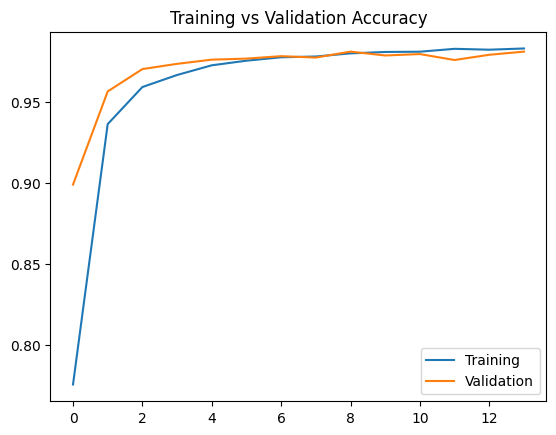

19/19 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step


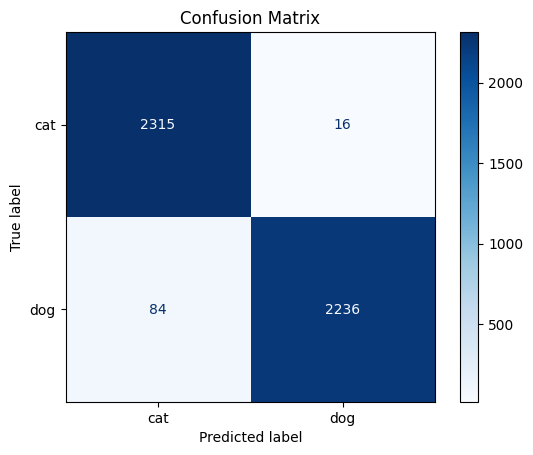

Confusion Matrix:
 [[2315   16]
 [  84 2236]]

Precision: 0.9929
Recall:    0.9638
F1-score:  0.9781

Classification Report:

              precision    recall  f1-score   support

         cat       0.96      0.99      0.98      2331
         dog       0.99      0.96      0.98      2320

    accuracy                           0.98      4651
   macro avg       0.98      0.98      0.98      4651
weighted avg       0.98      0.98      0.98      4651



In [ ]:
# ===============================
# 7. Evaluate Performance
# ===============================
plt.plot(history.history['accuracy'], label="Training")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Confusion Matrix
val_steps = validation_generator.samples // validation_generator.batch_size + 1
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
y_true = validation_generator.classes[:len(y_pred_classes)]

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(validation_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1-score
print("Confusion Matrix:\n", cm)

precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes,
                            target_names=list(validation_generator.class_indices.keys())))

In [ ]:
# ===============================
# 8. Save Model
# ===============================
model.save("cats_vs_dogs_finetuned.keras")
